In [137]:
# Data Manipulation
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Visualization (Static)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization (Interactive)
import plotly.express as px

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
# Packages for visualizing the tree
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
# Code for the bootstrap resample
from sklearn.utils import resample
from sklearn.tree import plot_tree

# Import Data 

In [152]:
# 1) All variables and countries from the master data
final_df_long= pd.read_csv("https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/master_data_long.csv")
final_df_long = final_df_long.drop(columns=['Unnamed: 0'], errors='ignore')

# 2) Clusters list from Leo
clusters_list = pd.read_csv('https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/clusters_list.csv')

In [ ]:
clusters_list

# Cluster variations across time 

### Pre-processing 

In [139]:
final_df_long[final_df_long['Variable'] == 'Economic Complexity Index'].isna().sum()

Country Code     0
Year             0
Variable         0
Value            0
Country Name    25
dtype: int64

In [140]:
windows = {
    3: ([1995, 1996, 1997], [2017, 2018, 2019]),
    5: ([1995, 1996, 1997, 1998, 1999], [2015, 2016, 2017, 2018, 2019]),
    7: ([1995, 1996, 1997, 1998, 1999, 2000, 2001], 
        [2013, 2014, 2015, 2016, 2017, 2018, 2019])
}

results = {}

for k, (start_years, end_years) in windows.items():

    df_k = final_df_long[
        final_df_long['Year'].isin(start_years + end_years)
    ].copy()

    pivot = df_k.pivot_table(
        index=['Country Code', 'Variable'],
        columns='Year',
        values='Value'
    )

    # Averages
    pivot['avg_start'] = pivot[start_years].mean(axis=1)
    pivot['avg_end']   = pivot[end_years].mean(axis=1)

    # Build variable-specific outcome
    pivot['value_out'] = pivot['avg_start']              # Average start years for all variables except ECI
    pivot.loc[
        pivot.index.get_level_values('Variable') == 'Economic Complexity Index', # For values assigned with ECI, replace value_out with net change 
        'value_out'
    ] = pivot['avg_end'] - pivot['avg_start']             # ECI net change

    # To wide
    df_out = pivot['value_out'].reset_index().pivot(
        index='Country Code',
        columns='Variable',
        values='value_out'
    )

    results[k] = df_out.merge(
        clusters_list,
        how='right',
        on='Country Code'
    )

# Final outputs
df_3_change_clusters = results[3]
df_5_change_clusters = results[5]
df_7_change_clusters = results[7]


#### NA check

In [141]:
df_3_change_clusters.isna().sum()

Country Code                                                                                    0
Access to electricity (% of population)                                                        30
Accountability index                                                                            1
Adjusted savings: gross savings (% of GNI)                                                     31
Adjusted savings: natural resources depletion (% of GNI)                                       13
Adjusted savings: total (current US$)                                                          35
Agriculture                                                                                     8
Capital depreciation rate                                                                       4
Capital stock (national accounts prices)                                                        4
Civil war                                                                                       1
Clientelism index   

In [142]:
df_5_change_clusters.isna().sum()

Country Code                                                                                    0
Access to electricity (% of population)                                                        24
Accountability index                                                                            1
Adjusted savings: gross savings (% of GNI)                                                     31
Adjusted savings: natural resources depletion (% of GNI)                                        9
Adjusted savings: total (current US$)                                                          33
Agriculture                                                                                     7
Capital depreciation rate                                                                       4
Capital stock (national accounts prices)                                                        4
Civil war                                                                                       1
Clientelism index   

In [143]:
df_7_change_clusters.isna().sum()

Country Code                                                                                    0
Access to electricity (% of population)                                                         1
Accountability index                                                                            1
Adjusted savings: gross savings (% of GNI)                                                     27
Adjusted savings: natural resources depletion (% of GNI)                                        7
Adjusted savings: total (current US$)                                                          30
Agriculture                                                                                     6
Capital depreciation rate                                                                       4
Capital stock (national accounts prices)                                                        4
Civil war                                                                                       1
Clientelism index   

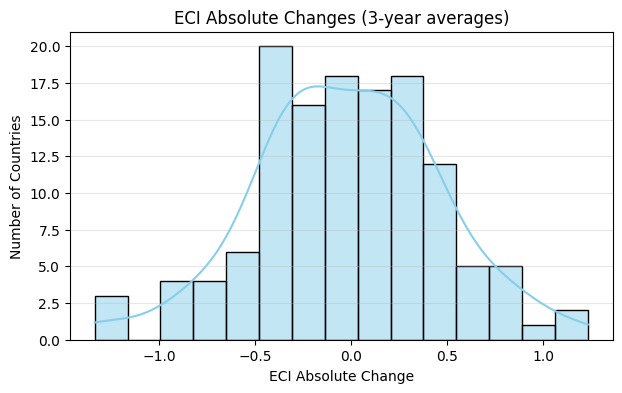

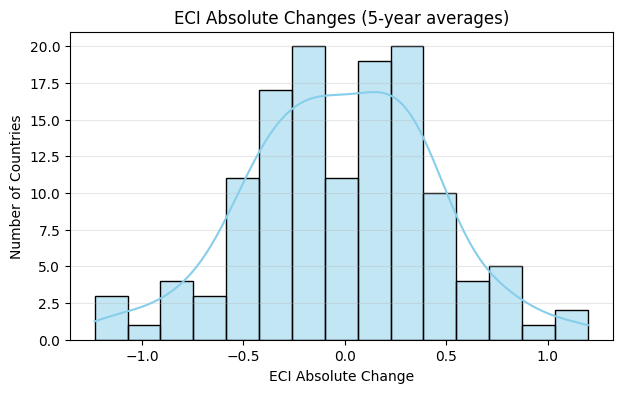

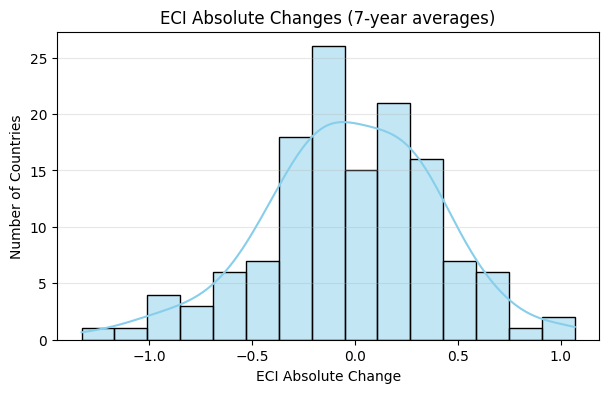

In [144]:
# Histogram of ECI changes
dfs = {
    3: df_3_change_clusters,
    5: df_5_change_clusters,
    7: df_7_change_clusters
}

for k, df in dfs.items():
    plt.figure(figsize=(7,4))
    sns.histplot(df['Economic Complexity Index'], bins=15, kde=True, color='skyblue')
    plt.title(f'ECI Absolute Changes ({k}-year averages)')
    plt.xlabel('ECI Absolute Change')
    plt.ylabel('Number of Countries')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

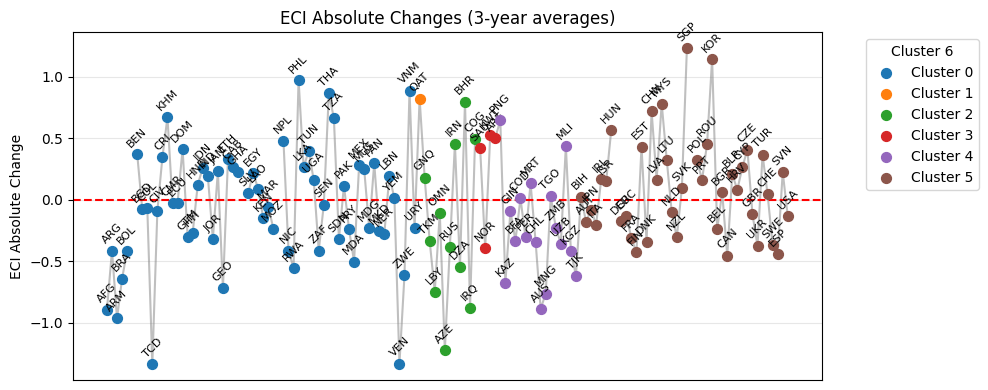

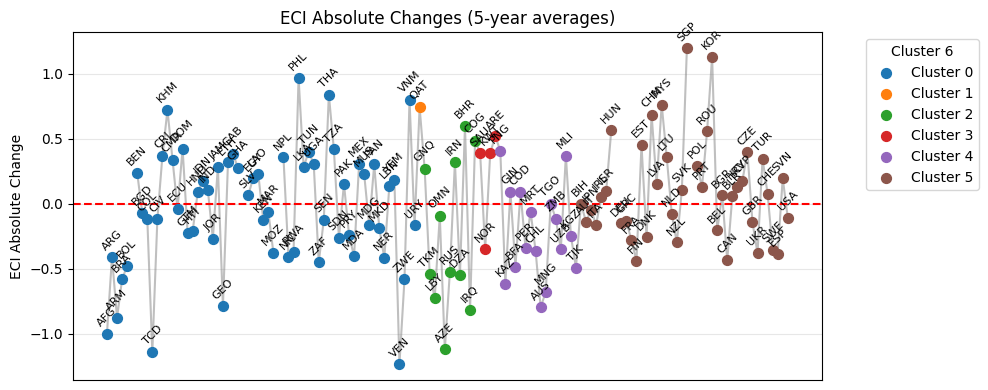

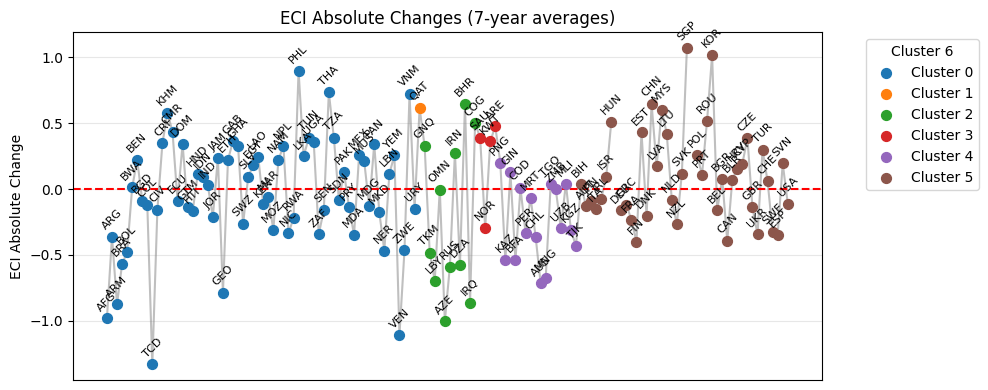

In [145]:
dfs = {
    3: df_3_change_clusters,
    5: df_5_change_clusters,
    7: df_7_change_clusters
}

for k, df in dfs.items():

    df_sorted = df.sort_values('cluster_6').reset_index(drop=True)

    plt.figure(figsize=(10,4))

    unique_clusters = df_sorted['cluster_6'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
    cluster_colors = dict(zip(unique_clusters, palette))

    # Line
    plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'],
             linestyle='-', color='gray', alpha=0.5)

    # Points + labels
    for cluster in unique_clusters:
        cluster_data = df_sorted[df_sorted['cluster_6'] == cluster]
        plt.scatter(cluster_data.index,
                    cluster_data['Economic Complexity Index'],
                    color=cluster_colors[cluster],
                    s=50,
                    label=f'Cluster {cluster}',
                    zorder=3)

        for i, row in cluster_data.iterrows():
            plt.text(i,
                     row['Economic Complexity Index'] + 0.04,
                     row['Country Code'],
                     ha='center',
                     va='bottom',
                     fontsize=8,
                     rotation=45)

    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.xticks([])
    plt.title(f'ECI Absolute Changes ({k}-year averages)')
    plt.ylabel('ECI Absolute Change')
    plt.grid(alpha=0.3)
    plt.legend(title='Cluster 6', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


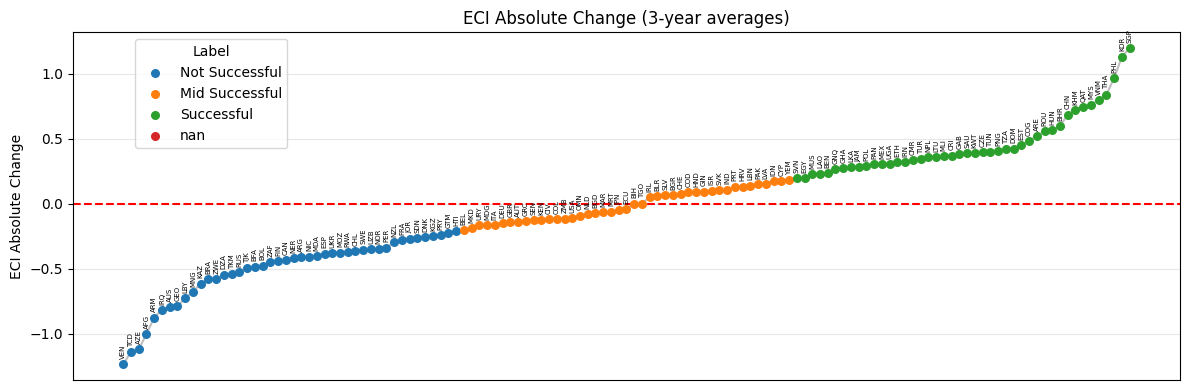

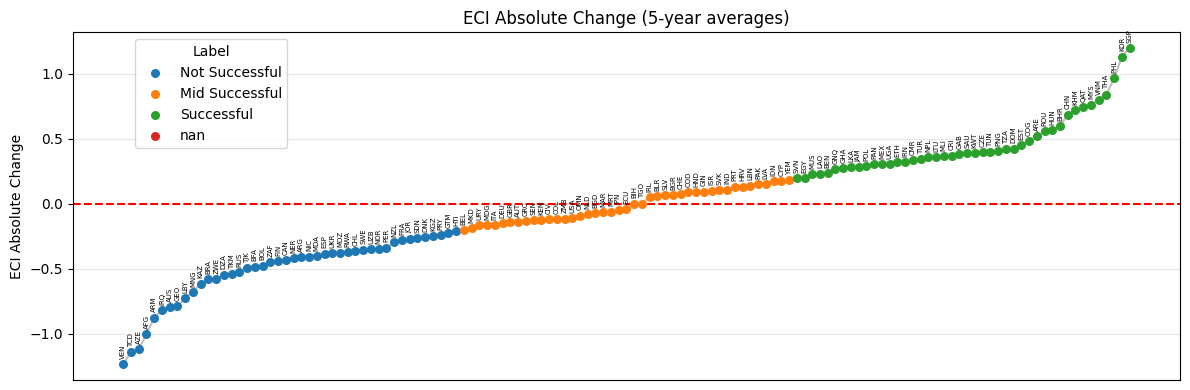

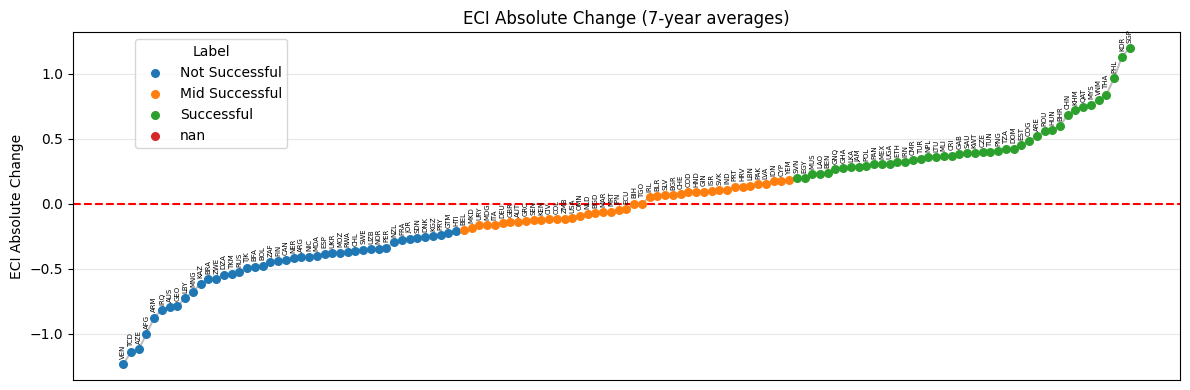

In [146]:
dfs = {
    3: df_3_change_clusters,
    5: df_5_change_clusters,
    7: df_7_change_clusters
}

for k, df in dfs.items():
    # Create a categorical variable with 3 equally sized groups
    df_5_change_clusters['label'] = pd.qcut(
        df_5_change_clusters['Economic Complexity Index'], 
        q=3,  # split into 3 quantiles
        labels=['Not Successful', 'Mid Successful', 'Successful']
        )

    # Sort by ECI change
    df_sorted = df_5_change_clusters.sort_values('Economic Complexity Index').reset_index(drop=True)

    plt.figure(figsize=(12,4))

    # Generate a color palette based on unique clusters
    unique_clusters = df_sorted['label'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
    cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

    # Plot line connecting points (gray)
    plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

    # Plot points colored by cluster and keep references for legend
    scatter_handles = []
    for cluster in unique_clusters:
        cluster_data = df_sorted[df_sorted['label'] == cluster]
        sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                         color=cluster_colors[cluster], s=30, label=f'{cluster}', zorder=3)
        scatter_handles.append(sc)
        # Annotate each point with country code
        for i, row in cluster_data.iterrows():
            plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                    ha='center', va='bottom', fontsize=5, rotation=90)

    # Remove x-axis labels
    plt.xticks([])
    # Add red dashed horizontal line at 0
    plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)
    plt.title(f'ECI Absolute Change ({k}-year averages)')
    plt.xlabel('')
    plt.ylabel('ECI Absolute Change')
    plt.grid(alpha=0.3)
    plt.legend(title='Label', bbox_to_anchor=(.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## LASSO

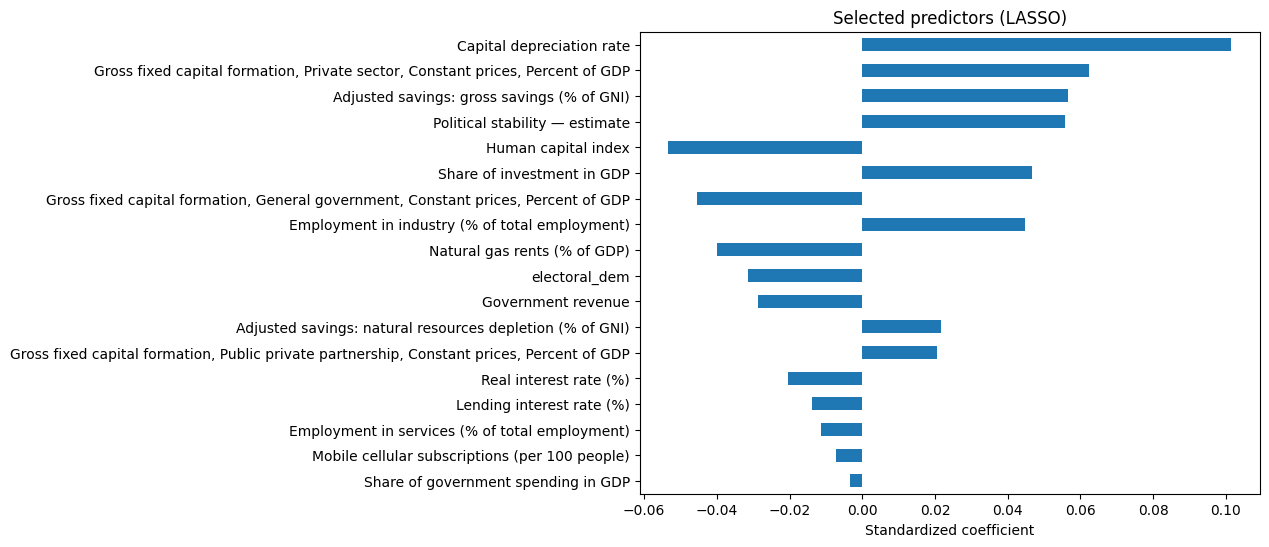

In [147]:
# ----------------------------
# 1. Drop rows with missing outcome
# ----------------------------
df_clean = df_5_change_clusters.dropna(subset=['Economic Complexity Index']).copy()
df_clean = df_clean.dropna(axis=1, how='all')

# ----------------------------
# 2. Separate outcome and predictors
# ----------------------------
y = df_clean['Economic Complexity Index'].values

X = df_clean.drop(columns=['Country Code', 'Country Name', 'cluster_6', 'Economic Complexity Index', 'label']).values
feature_names = df_clean.drop(columns=['Country Code', 'Country Name', 'cluster_6', 'Economic Complexity Index', 'label']).columns

# ----------------------------
# 3. Impute missing predictor values
# ----------------------------
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# ----------------------------
# 4. Standardize predictors
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ----------------------------
# 5. LASSO with cross-validation
# ----------------------------
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)

# ----------------------------
# 6. Extract coefficients (indexed by feature names, not rows!)
# ----------------------------
coef = pd.Series(lasso_cv.coef_, index=feature_names)
#print("LASSO coefficients:\n", coef)

# ----------------------------
# 7. Selected predictors (non-zero coefficients)
# ----------------------------
selected = coef[coef != 0].sort_values(key=abs, ascending=False)
#print("Selected predictors:\n", selected)

# ----------------------------
# 8. Optional: Plot
# ----------------------------
plt.figure(figsize=(8,6))
selected.plot(kind='barh')
plt.title("Selected predictors (LASSO)")
plt.xlabel("Standardized coefficient")
plt.gca().invert_yaxis()
plt.show()


## Single tree

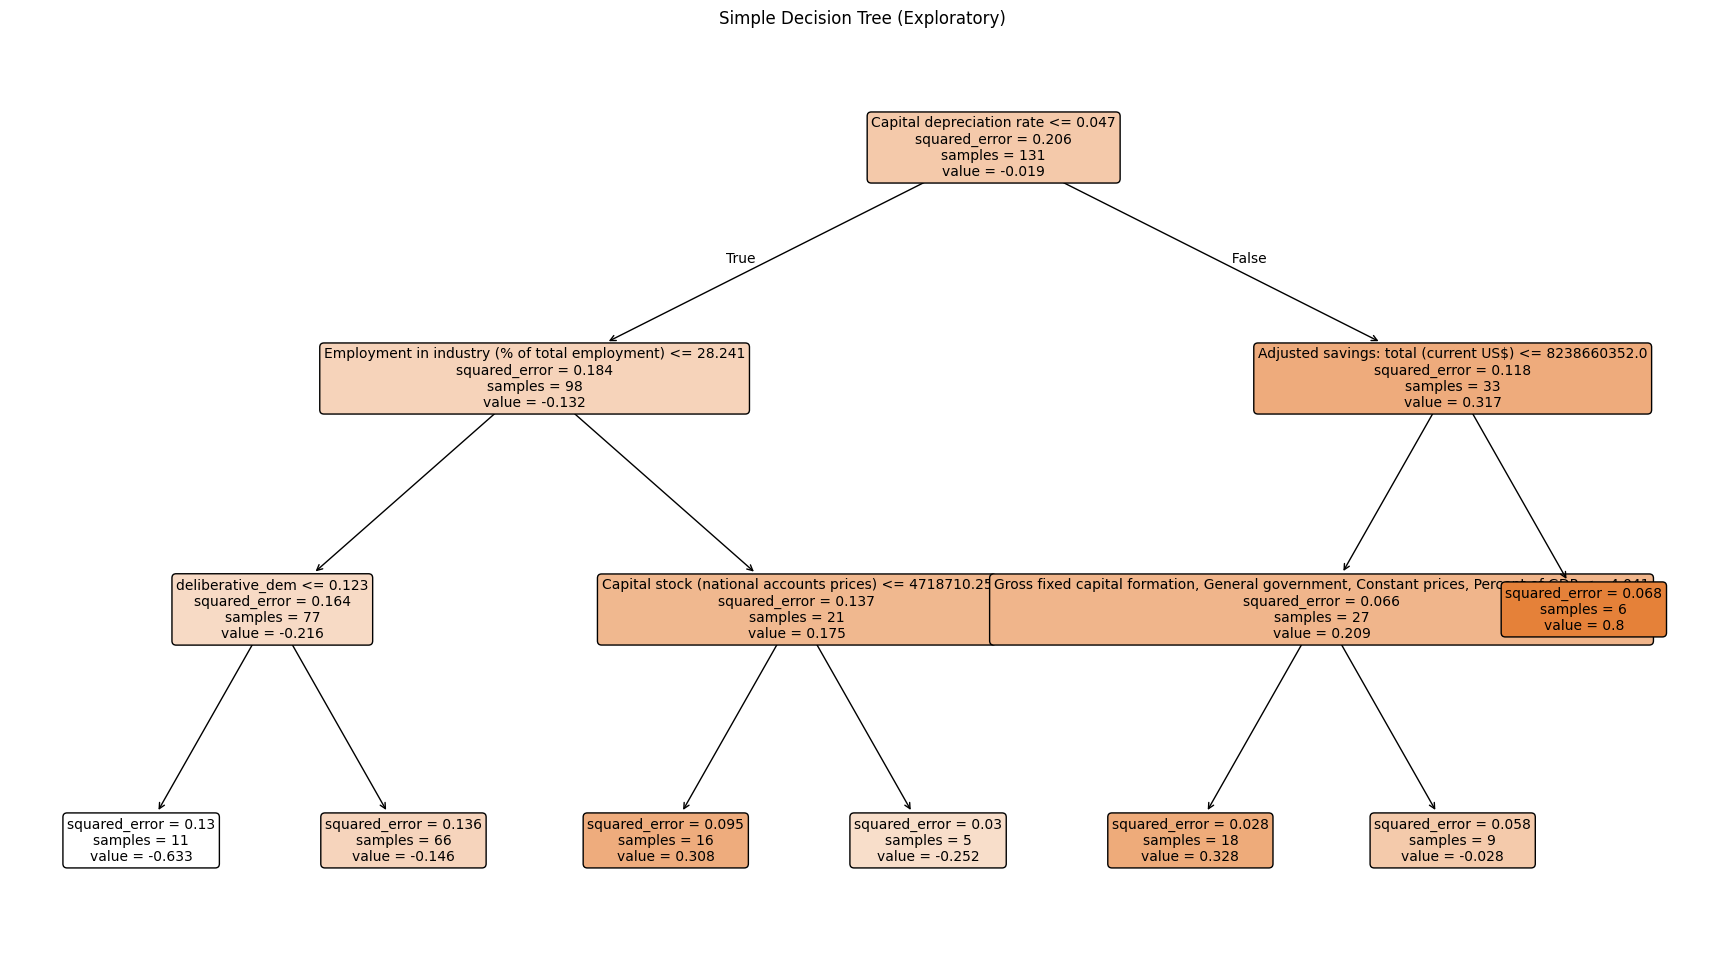

In [148]:
# ----------------------------
# 1. Drop rows with missing outcome
# ----------------------------
df_clean = df_5_change_clusters.dropna(
    subset=['Economic Complexity Index']
).copy() # Drops rows with missing ECI

df_clean = df_clean.dropna(axis=1, how='all') # Drops all missing columns (they don't have data for the start year)

# ----------------------------
# 2. Separate outcome and predictors
# ----------------------------
y = df_clean['Economic Complexity Index'].values

X_df = df_clean.drop(
    columns=['Country Code', 'Country Name', 'cluster_6',
             'Economic Complexity Index', 'label'],
    errors='ignore'
)

feature_names = X_df.columns
X = X_df.values

# ----------------------------
# 3. Impute missing predictor values
# ----------------------------
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# ----------------------------
# 4. Fit simple decision tree
# ----------------------------
tree_simple = DecisionTreeRegressor(
    max_depth=3,          # shallow & interpretable
    min_samples_leaf=5,
    random_state=42
)

tree_simple.fit(X_imputed, y)

# ----------------------------
# 5. Visualize simple tree
# ----------------------------
plt.figure(figsize=(22, 12))
plot_tree(
    tree_simple,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title("Simple Decision Tree (Exploratory)")
plt.show()


## Random Forest

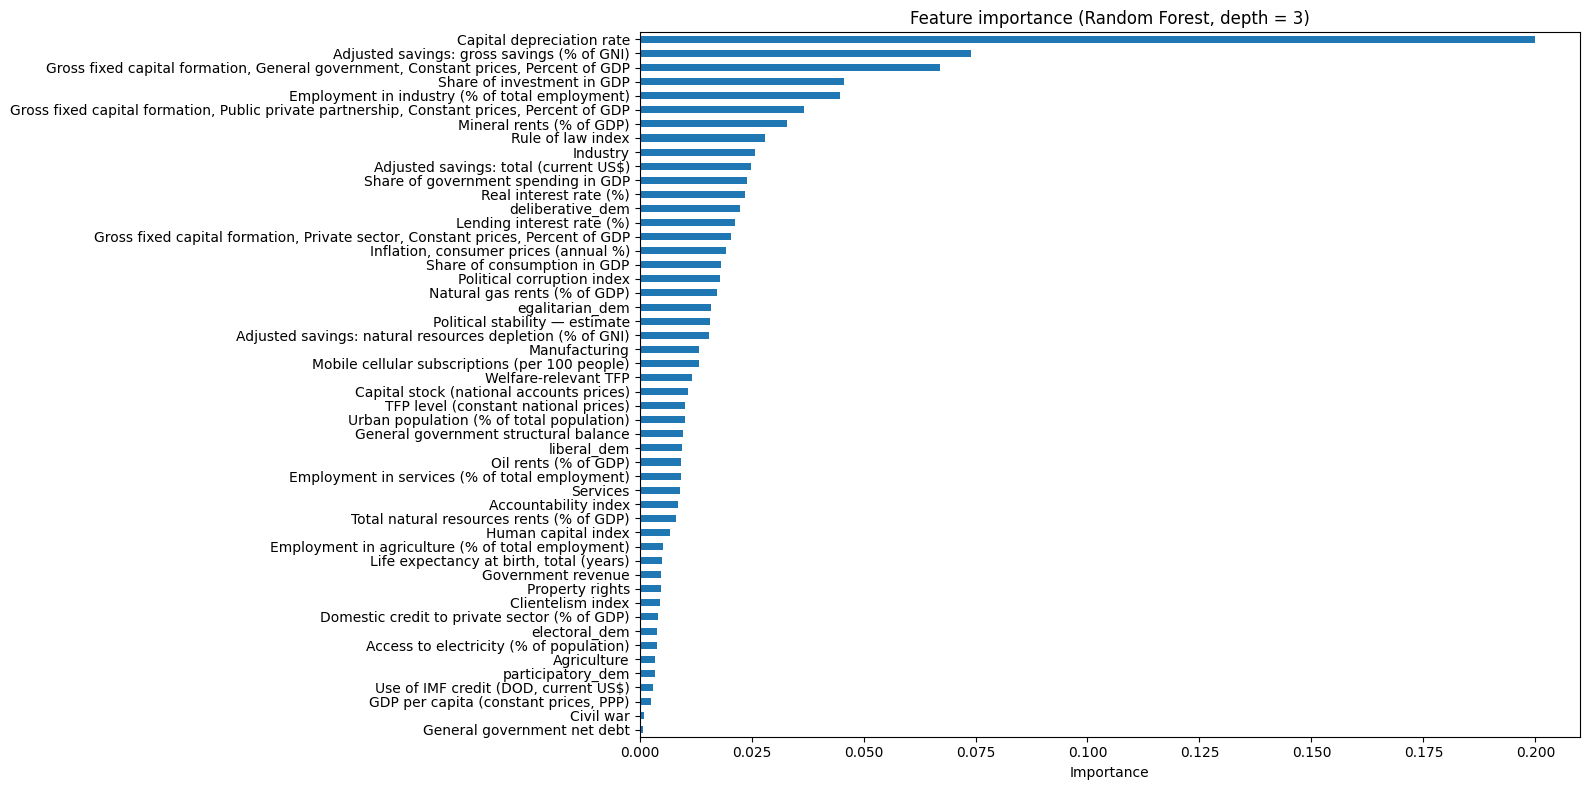

In [151]:
# ----------------------------
# 6. Random Forest (3 levels)
# ----------------------------
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=4,          # <-- 3 levels
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_imputed, y)

# ----------------------------
# 7. Feature importance
# ----------------------------
importance = pd.Series(
    rf.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

#print("Random Forest feature importance:\n", importance)

# ----------------------------
# 7. Plot importance
# ----------------------------
plt.figure(figsize=(16,8))
importance.plot(kind='barh')
plt.title("Feature importance (Random Forest, depth = 3)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()